2025-03-10 18:33:52.159277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


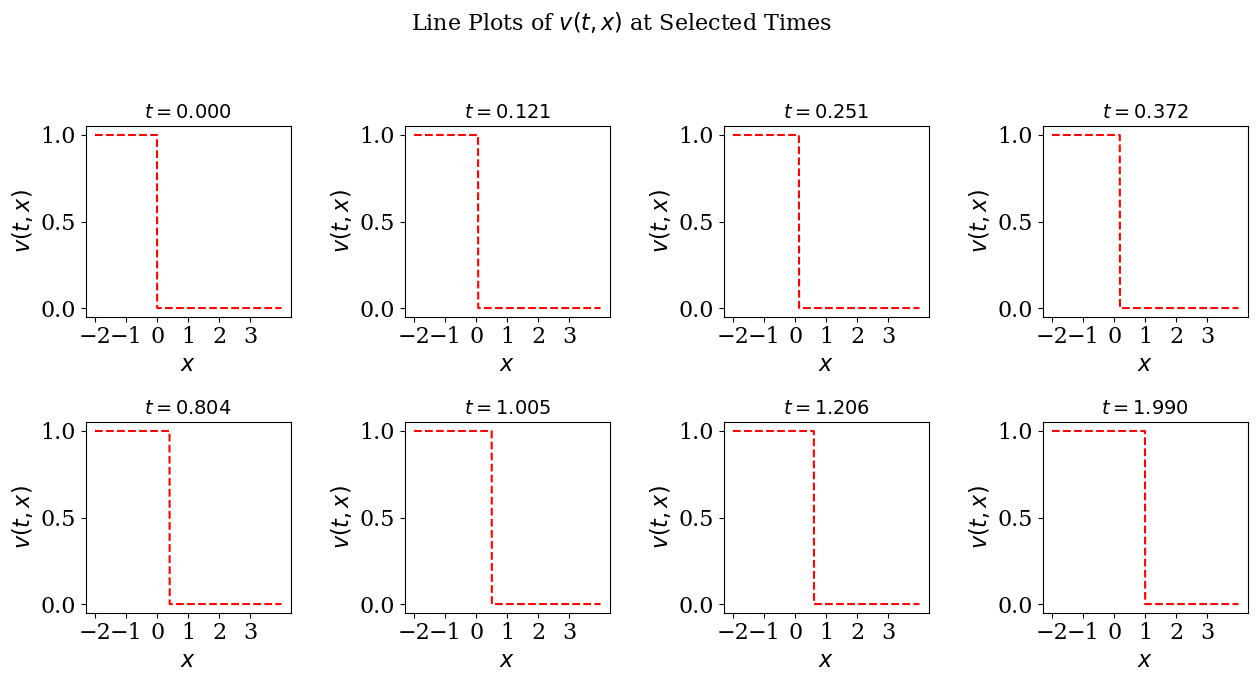

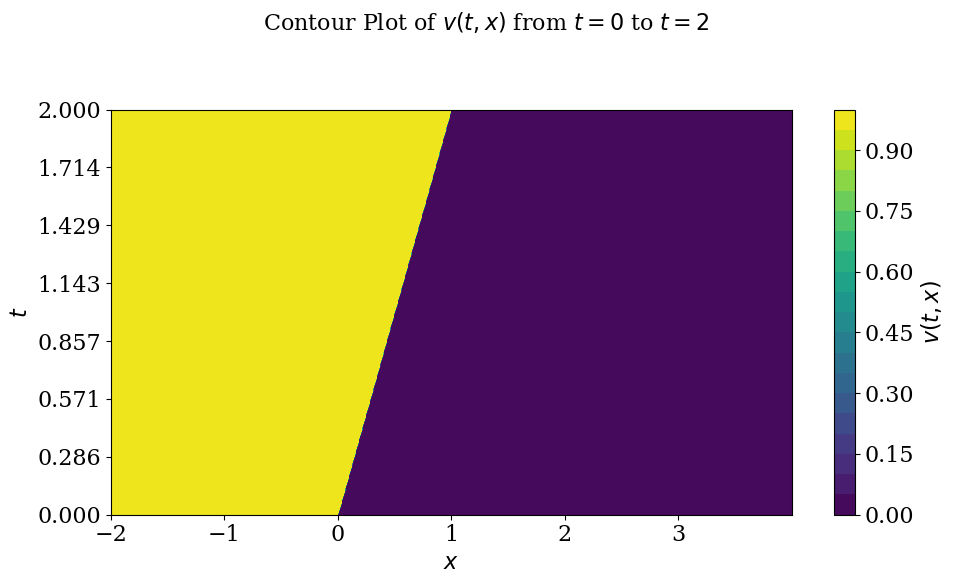

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Set matplotlib styles
plt.rc('font', family='serif')
plt.rc('lines', linewidth=1.5)
plt.rc('font', size=16)
plt.rc('legend', fontsize=11)

DTYPE = 'float32'
DTYPE_SV = 'f32'
#DTYPE = 'float64'  ##Error. Fix 
#DTYPE_SV = 'f64'

IB = 1 # Choice of Initial/Boundary Condition. 0 is our example.

pi = tf.constant(np.pi, dtype=DTYPE)

# Define all exact solution functions with (t, x) parameters
def fun_exact_0(t, x):
    """Exact solution for IB=0: -sin(pi*x), time-independent. Wrong. Need to reinsert the correct version"""
    return -tf.sin(pi * x)

def fun_exact_1(t, x):
    """Exact solution for IB=1: step function at x = 0.5*t."""
    return tf.where(x < 0.5*t, tf.constant(1.0, dtype=DTYPE), tf.constant(0.0, dtype=DTYPE))

#def fun_exact_1(t ,x):
 #   """Exact solution for IB=1: step function at x = 0.5*t."""
#    cond1 = tf.cast(tf.math.less_equal(x, 0.5 * t), dtype=DTYPE)
#    cond2 = tf.cast(tf.math.greater(x, 0.5 * t), dtype=DTYPE)
#    a = tf.math.multiply(cond1, tf.constant(1.0, dtype=DTYPE))
#    b = tf.math.multiply(cond2, tf.constant(0.0, dtype=DTYPE))
#    return a + b

def fun_exact_2(t, x):
    """Exact solution for IB=2 with division by (1-t) protection."""
    t_safe = tf.cond(t == 1.0, lambda: tf.constant(1.0 - 1e-10, dtype=DTYPE), lambda: t)
    denom = tf.constant(1.0, dtype=DTYPE) - t_safe
    b_part = tf.where((x < 1.0) & (x > t), (tf.constant(1.0, dtype=DTYPE) - x)/denom, tf.constant(0.0, dtype=DTYPE))
    a_part = tf.where(x <= t, tf.constant(1.0, dtype=DTYPE), tf.constant(0.0, dtype=DTYPE))
    c_part = tf.where(x >= 1.0, tf.constant(0.0, dtype=DTYPE), tf.constant(0.0, dtype=DTYPE))
    return a_part + b_part + c_part



def fun_exact_3(t, x):
    """Exact solution for IB=3 with division by t protection."""
    t_safe = tf.cond(t == 0, lambda: 1e-10, lambda: t)
    cond1 = tf.cast(x <= 0, DTYPE)
    cond2 = tf.cast((x < t) & (x > 0), DTYPE)
    cond3 = tf.cast(x >= t, DTYPE)
    a = tf.multiply(cond1, 0.0)
    b = tf.multiply(cond2, x / t_safe)
    c = tf.multiply(cond3, 1.0)
    return a + b + c

def fun_exact_4(t, x):
    """Exact solution for IB=4 with multiple regions and t protection."""
    t_safe = tf.cond(t == 0, lambda: 1e-10, lambda: t)
    
    cond00 = tf.cast((x < 0.0) & (t == 0.0), DTYPE)
    cond01 = tf.cast((x <= 1) & (x >= 0.0) & (t == 0.0), DTYPE)
    cond02 = tf.cast((x > 1.0) & (t == 0.0), DTYPE)
    
    cond10 = tf.cast((x < 0.0) & (t >= 0.0) & (t < 2.0), DTYPE)
    cond11 = tf.cast((x < t) & (x >= 0.0) & (t > 0.0) & (t < 2.0), DTYPE)
    cond12 = tf.cast((x >= t) & (x <= 1.0 + t/2.0) & (t > 0.0) & (t < 2.0), DTYPE)
    cond13 = tf.cast((x > 1.0 + t/2.0) & (t > 0.0) & (t < 2.0), DTYPE)
    
    cond20 = tf.cast((x <= 0.0) & (t >= 2.0), DTYPE)
    cond21 = tf.cast((x >= 0.0) & (x <= tf.sqrt(2.0*t)) & (t >= 2.0), DTYPE)
    cond22 = tf.cast((x > tf.sqrt(2.0*t)) & (t >= 2.0), DTYPE)
    
    a = tf.multiply(cond00, 0.0)
    b = tf.multiply(cond01, 1.0)
    c = tf.multiply(cond02, 0.0)
    
    d = tf.multiply(cond10, 0.0)
    e = tf.multiply(cond11, x / t_safe)
    f = tf.multiply(cond12, 1.0)
    g = tf.multiply(cond13, 0.0)
    
    h = tf.multiply(cond20, 0.0)
    i = tf.multiply(cond21, x / t_safe)
    j = tf.multiply(cond22, 0.0)
    
    if t == 0.0:
        return a + b + c
    elif 0.0 < t < 2.0:
        return d + e + f + g
    else:
        return h + i + j
    
def fun_exact_5(t,x):
    t_safe = tf.cond(t == 0, lambda: tf.constant(1e-10, dtype=DTYPE), lambda: t)
    u = tf.zeros_like(x, dtype=DTYPE)
    u = tf.where(x < 1.25 * t, tf.constant(2.0, dtype=DTYPE), u)
    u = tf.where((1.25 * t <= x) & (x < 1 + 0.5 * t), tf.constant(0.5, dtype=DTYPE), u)
    u = tf.where((1 + 0.5 * t <= x) & (x < 1 + 1.5 * t), (x - tf.constant(1.0, dtype=DTYPE)) / t_safe, u)
    u = tf.where((1 + 1.5 * t <= x) & (x < 0.75 * t + 2), tf.constant(1.5, dtype=DTYPE), u)
    u = tf.where(x >= 0.75 * t + 2, tf.constant(0.0, dtype=DTYPE), u)
    return u

def fun_exact_6(t, x):
    """Exact solution for Burgers' equation with LeVeq's Riemann solver."""
    t = tf.convert_to_tensor(t, dtype=DTYPE)
    x = tf.convert_to_tensor(x, dtype=DTYPE)
    
    # Critical time when shock meets rarefaction
    t_c = tf.constant(8.0 / 11.0, dtype=DTYPE)
    
    # Shock position
    x_s = tf.where(
        t < t_c,
        tf.constant(-1.0, dtype=DTYPE) + 1.25 * t,
        4.0 * t + tf.constant(1.0, dtype=DTYPE) - tf.sqrt(tf.constant(22.0, dtype=DTYPE)) * tf.sqrt(t)
    )
    
    # Initial condition
    u_initial = tf.where(
        x <= -1.0,
        tf.constant(4.0, dtype=DTYPE),
        tf.where(
            x <= 1.0,
            tf.constant(-1.5, dtype=DTYPE),
            tf.constant(0.5, dtype=DTYPE)
        )
    )
    
    # Rarefaction solution
    u_rarefaction = (x - tf.constant(1.0, dtype=DTYPE)) / (t + tf.constant(1e-9, dtype=DTYPE))
    
    # Full solution
    u = tf.where(
        t == 0.0,
        u_initial,
        tf.where(
            x < x_s,
            tf.constant(4.0, dtype=DTYPE),
            tf.where(
                x < 1.0 - 1.5 * t,
                tf.constant(-1.5, dtype=DTYPE),
                tf.where(
                    x <= 1.0 + 0.5 * t,
                    u_rarefaction,
                    tf.constant(0.5, dtype=DTYPE)
                )
            )
        )
    )
    
    return u
""" 
def fun_exact_7(t, x):
   
    #Exact solution for the 1D inviscid Burgers equation with given initial and boundary conditions.
    #Handles two shocks merging at t = 1.
    
    t = tf.convert_to_tensor(t, dtype=DTYPE)
    x = tf.convert_to_tensor(x, dtype=DTYPE)
    
    # Critical time when the two shocks meet
    t_c = tf.constant(1.0, dtype=DTYPE)
    
    # Shock positions
    # For t < 1: two shocks at x = -1 + 3t and x = 1 + t
    # For t >= 1: single shock at x = 2t
    x_s1 = -1.0 + 3.0 * t  # First shock position (speed 3)
    x_s2 = 1.0 + t         # Second shock position (speed 1)
    x_s_merged = 2.0 * t   # Merged shock position (speed 2)
    
    # Initial condition at t = 0
    u_initial = tf.where(x <= -1.0, tf.constant(4.0, dtype=DTYPE),
                         tf.where(x <= 1.0, tf.constant(2.0, dtype=DTYPE),
                                  tf.constant(0.0, dtype=DTYPE)))
    
    # Protect against t = 0 for division or comparisons
    t_safe = tf.where(t == 0, tf.constant(1e-10, dtype=DTYPE), t)
    
    # Initialize output tensor
    u = tf.zeros_like(x, dtype=DTYPE)
    
    # Full solution
    u = tf.where(t == 0.0, u_initial,  # Apply initial condition at t = 0
                 tf.where(t < t_c,
                          # For t < 1: two shocks
                          tf.where(x < x_s1, tf.constant(4.0, dtype=DTYPE),
                                   tf.where(x < x_s2, tf.constant(2.0, dtype=DTYPE),
                                            tf.constant(0.0, dtype=DTYPE))),
                        # For t >= 1: single shock
                          tf.where(x < x_s_merged, tf.constant(4.0, dtype=DTYPE),
                                  tf.constant(0.0, dtype=DTYPE))))
    return u
"""
def difference(t, x):
    """Difference of Exact solutions IB=6 and IB=61"""
    u = tf.zeros_like(x, dtype=DTYPE)
    u1 = tf.zeros_like(x, dtype=DTYPE)
    u2 = tf.zeros_like(x, dtype=DTYPE)

    u1 = fun_exact_6(t, x)
    u2 = fun_exact_61(t, x)
    u = u1-u2
 #   u = fun_exact_6(t, x) - fun_exact_61(t, x)
    return u
    
# Select the appropriate function based on IB
fun_exact_dict = {
    0: fun_exact_0,
    1: fun_exact_1,
    2: fun_exact_2,
    3: fun_exact_3,
    4: fun_exact_4,
    5: fun_exact_5,
    6: fun_exact_6,
    99: difference
}


try:
    fun_exact = fun_exact_dict[IB]
except KeyError:
    raise ValueError(f"Invalid IB value: {IB}")

# Grid setup for IBs
Nx = 1000   #IB=2
x_max = 4.0 #IB=2
x_min = -2.0 #IB=6
#Nx = 1000   #IB=0
#x_max = 2.0 #IB=0
#x_min = 0.0 #IB=0

dx = (x_max - x_min) / (Nx - 1)
x = tf.constant(np.linspace(x_min, x_max, Nx), dtype=DTYPE)

t_int = 0.0
t_end = 2.0 
#t_end = 4 # For longer time
dt = (t_end - t_int) / 200  # Adjusted to maintain similar dt (~0.01)
Nt = int(t_end / dt)
t = tf.constant(np.linspace(t_int, t_end, Nt), dtype=DTYPE)

# Compute solution using vectorized operation
#v = tf.map_fn(lambda ti: fun_exact(ti, x), t)
v = tf.map_fn(lambda ti: fun_exact(ti, x), t, dtype=DTYPE)

# Save data
np.save(f"../data/exact_data{IB}_{DTYPE_SV}_x", x.numpy())
np.save(f"../data/exact_data{IB}_{DTYPE_SV}_t", t.numpy())
np.save(f"../data/exact_data{IB}_{DTYPE_SV}_v", v.numpy())

# Plotting setup for line plots
mid1 = int(np.floor(t.shape[0]/16))
mid2 = int(np.floor(2*t.shape[0]/16))
mid3 = int(np.floor(3*t.shape[0]/16))
mid4 = int(np.floor(4*t.shape[0]/10))
mid5 = int(np.floor(5*t.shape[0]/10))
mid6 = int(np.floor(6*t.shape[0]/10))

# First figure: Line plots
fig1, axs1 = plt.subplots(nrows=2, ncols=4, figsize=(13, 7))
fig1.suptitle('Line Plots of $v(t,x)$ at Selected Times', fontsize=16)

times = [0, mid1, mid2, mid3, mid4, mid5, mid6, -2]
for i, (ax, time_idx) in enumerate(zip(axs1.flatten(), times)):
    t_val = t[time_idx].numpy()
    ax.set_title(f'$t = {t_val:.3f}$', fontsize=14)
    ax.plot(x.numpy(), v[time_idx].numpy(), '--', color='red')
    ax.set_xlabel('$x$')
    ax.set_ylabel("$v(t, x)$")
    ax.set_xticks(np.arange(x_min, x_max, 1.0))

fig1.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle

# Second figure: Single contour plot over t=[0, 2.0]
fig2, ax2 = plt.subplots(figsize=(10, 6))
fig2.suptitle('Contour Plot of $v(t,x)$ from $t=0$ to $t=2$', fontsize=16)

# Use time range from 0 to 2.0
t_max = t_end
end_idx = np.argmin(np.abs(t.numpy() - t_max)) + 1  # Include t=2.0
#t_window = t[:end_idx].numpy()  # From t=0 to t=2.0
#v_window = v[:end_idx].numpy()
#X_window, T_window = np.meshgrid(x.numpy(), t_window)  # Shapes: (end_idx, Nx)
#--------For all time
t_window = t[:-1].numpy()  # From t=0 to t=t_end
v_window = v[:-1].numpy()
X_window, T_window = np.meshgrid(x.numpy(), t_window)  # Shapes: (end_idx, Nx)

contour = ax2.contourf(X_window, T_window, v_window, levels=20, cmap='viridis')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$t$')
#ax2.set_ylim(0, 2.0)  # Explicitly set y-axis range to [0, 2.0]
ax2.set_ylim(0, t_end)  # Explicitly set y-axis range to [0, t_end]
ax2.set_xticks(np.arange(x_min, x_max, 1.0))
#ax2.set_yticks(np.linspace(0, 2.0, 5))  # Show time ticks between [0, 2.0]
ax2.set_yticks(np.linspace(0, t_end, 8))  # Show time ticks between [0, t_end]
plt.colorbar(contour, ax=ax2, label='$v(t,x)$')

fig2.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle

plt.show()

In [3]:
print(t.shape, x.shape, v.shape)

(401,) (1000,) (401, 1000)
